# Predicting Telco Customer Churn using SparkML on IBM Cloud Pak for Data (ICP4D)

In [5]:
!pip install seaborn scikit-learn --quiet


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()


Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (1).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
# Drop unnecessary column
df.drop('customerID', axis=1, inplace=True)

# Handle TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode binary categorical columns
le = LabelEncoder()
for column in df.select_dtypes(include='object'):
    if df[column].nunique() == 2:
        df[column] = le.fit_transform(df[column])
    else:
        df = pd.get_dummies(df, columns=[column])


<ipython-input-12-82000af95b27>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.49      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[946  90]
 [190 183]]


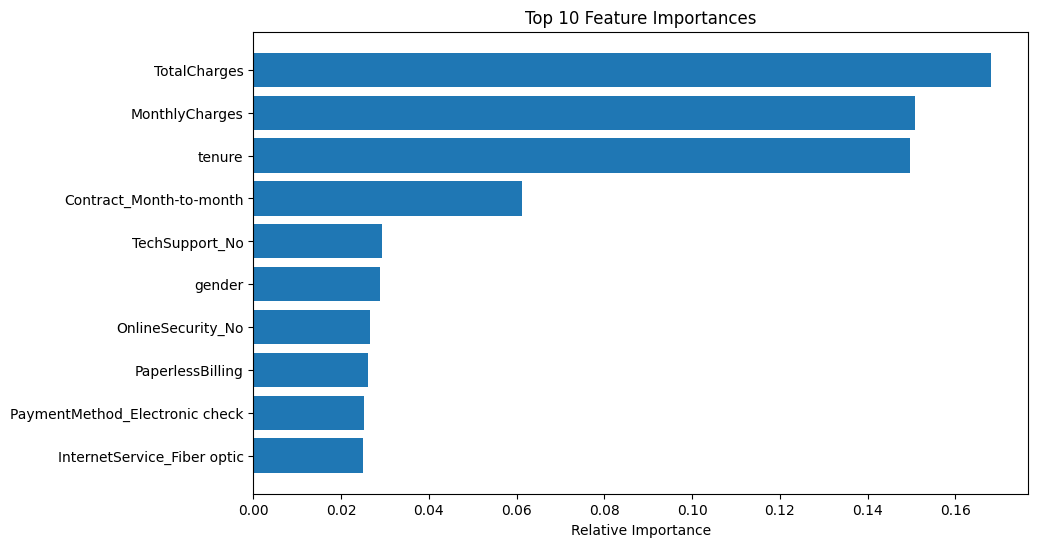

In [16]:
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


In [17]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.801277501774308


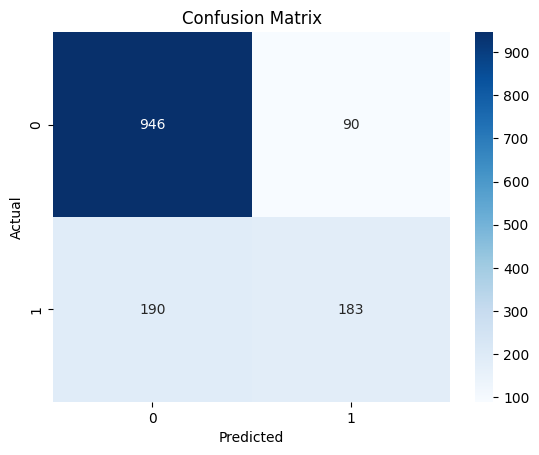

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
import joblib
joblib.dump(model, 'rf_churn_model.pkl')


['rf_churn_model.pkl']

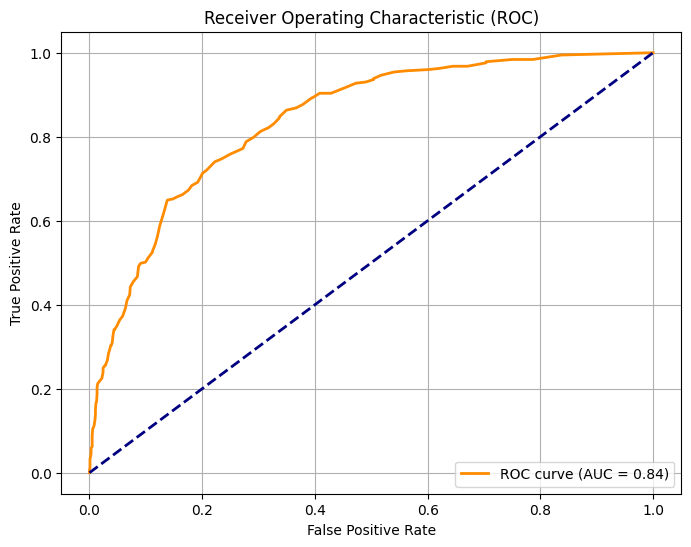

In [20]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<ipython-input-21-90642a38f32a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


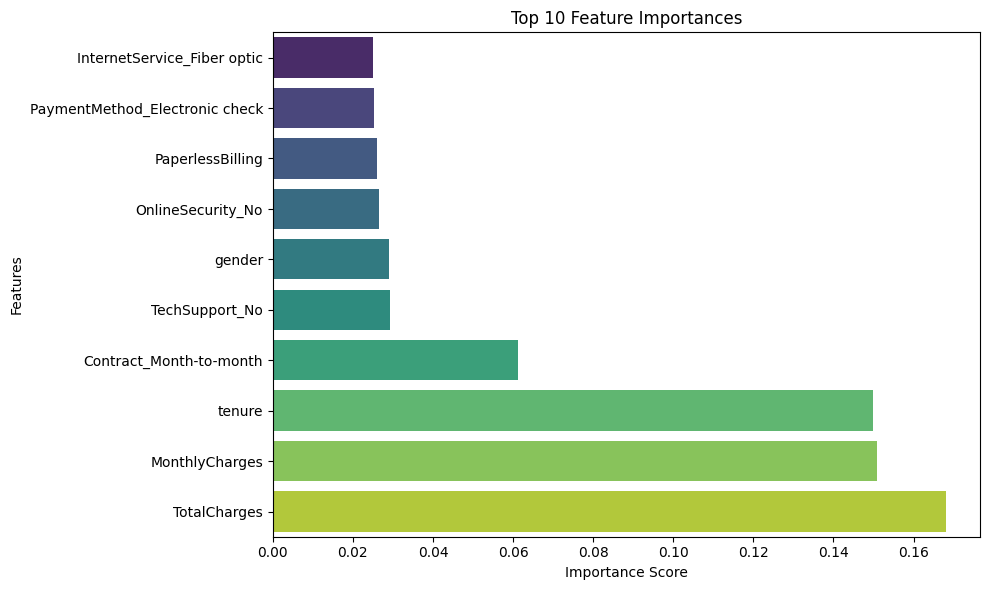

In [21]:
# Get feature importances
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]  # Top 10

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
